In [1]:
# Just read the data files and merge all the data in single CSV , so the data is in column wise format

import os
import numpy as np
if not os.path.isfile("ProjectData.csv"): 
  openCSV = open("ProjectData.csv", mode = "w")
  dataFiles = ['combined_data_2.txt', 'combined_data_4.txt']
  #dataFiles = ['combined_data_2.txt']
  for dataFile in dataFiles:
     with open(dataFile) as f:
       for eachLine in f:
          eachLine = eachLine.strip() 
          if eachLine.endswith(":"):
              movieID = eachLine.replace(":", "")
          else:
              movieData = [] 
              movieData = [line for line in eachLine.split(",")]
              movieData.insert(0, movieID)
              openCSV.write(",".join(movieData))
              openCSV.write("\n")        
  openCSV.close()
print("Files combination completed")   

Files combination completed


In [0]:
# from csv file, create dataframe for the models

import pandas as pd
from datetime import datetime

if not os.path.isfile("ProjectData.pkl"):  
    dataFrame = pd.read_csv("ProjectData.csv", sep=",", names = ["Movie_ID","User_ID", "Movie_Ratings", "Rating_Date"])
    dataFrame["Rating_Date"] = pd.to_datetime(dataFrame["Rating_Date"])
    dataFrame.sort_values(by = "Rating_Date", inplace = True)
    dataFrame.to_pickle("ProjectData.pkl")
else:
    dataFrame = pd.read_pickle("ProjectData.pkl")


In [3]:
# Data PreProcessing

# 1 Find out if there are null Values in Data
if (dataFrame.isnull().sum()).all() != 0:
  print("There is Data which has Null Values")
else:
  print("No Null Values found in Data")

# 2 Find out if there are duplicate entry in Data
lineDuplicated = dataFrame.duplicated(["Movie_ID","User_ID", "Movie_Ratings"])
if (lineDuplicated.sum()) != 0:
  print("There is no Duplicate Data")
else:
  print("There is Duplicate Data in file")

#3 Spliting the data in to Training and Test DataSet , the data is splited in 80, 20 ratio on random
if not os.path.isfile("Training_Data.pkl"):
    dataFrame.iloc[:int(dataFrame.shape[0]*0.80)].to_pickle("Training_Data.pkl")
    trainingData = pd.read_pickle("Training_Data.pkl")
    trainingData.reset_index(drop = True, inplace = True)
else:
    trainingData = pd.read_pickle("Training_Data.pkl")
    trainingData.reset_index(drop = True, inplace = True)

if not os.path.isfile("Testing_Data.pkl"):
    dataFrame.iloc[int(dataFrame.shape[0]*0.80):].to_pickle("Testing_Data.pkl")
    testingData = pd.read_pickle("Testing_Data.pkl") 
    testingData.reset_index(drop = True, inplace = True)   
else:
    testingData = pd.read_pickle("Testing_Data.pkl")
    testingData.reset_index(drop = True, inplace = True)

print("Data splited for training and testing")


No Null Values found in Data
There is Duplicate Data in file
Data splited for training and testing


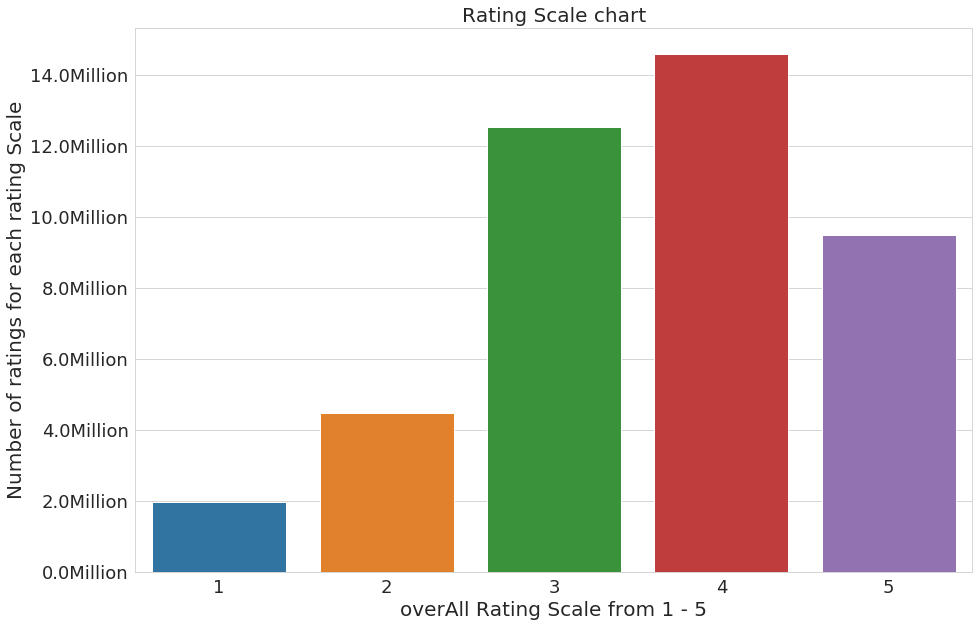

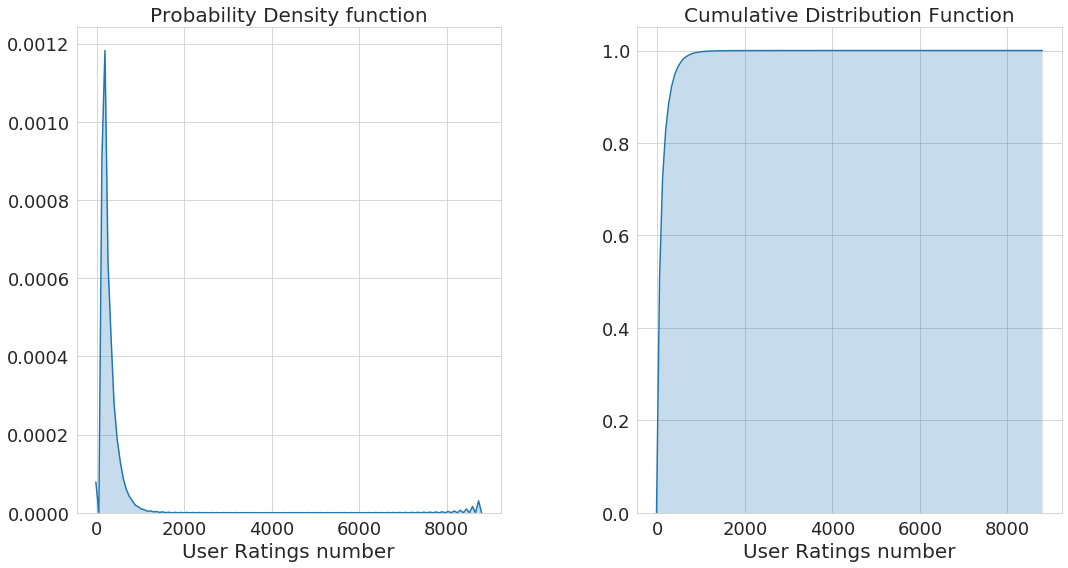

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Graph 1 : showing over all rating by rating Scale

# Rate scale plotting on X axis
def changingLabels(number):
    return str(number/10**6) + "Million"

plt.figure(figsize = (15, 10))
barPlot = sns.countplot(x="Movie_Ratings", data=trainingData)

barPlot.set_yticklabels([changingLabels(rating) for rating in barPlot.get_yticks()])

plt.tick_params(labelsize = 18)
plt.title("Rating Scale chart", fontsize = 20)
plt.xlabel("overAll Rating Scale from 1 - 5", fontsize = 20)
plt.ylabel("Number of ratings for each rating Scale", fontsize = 20)
plt.show()

# Graph 2:  showing rating's per user

userRatings = trainingData.groupby(by = "User_ID")["Movie_Ratings"].count()
plot, graph = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8))

sns.kdeplot(userRatings.values, shade = True, ax = graph[0])
graph[0].set_title("Probability Density function", fontsize = 20)
graph[0].set_xlabel("User Ratings number", fontsize = 20)
graph[0].tick_params(labelsize = 18)

sns.kdeplot(userRatings.values, shade = True, cumulative = True, ax = graph[1])
graph[1].set_title("Cumulative Distribution Function", fontsize = 20)
graph[1].set_xlabel("User Ratings number", fontsize = 20)
graph[1].tick_params(labelsize = 18)

plot.subplots_adjust(wspace=3)
plt.tight_layout()
plt.show()

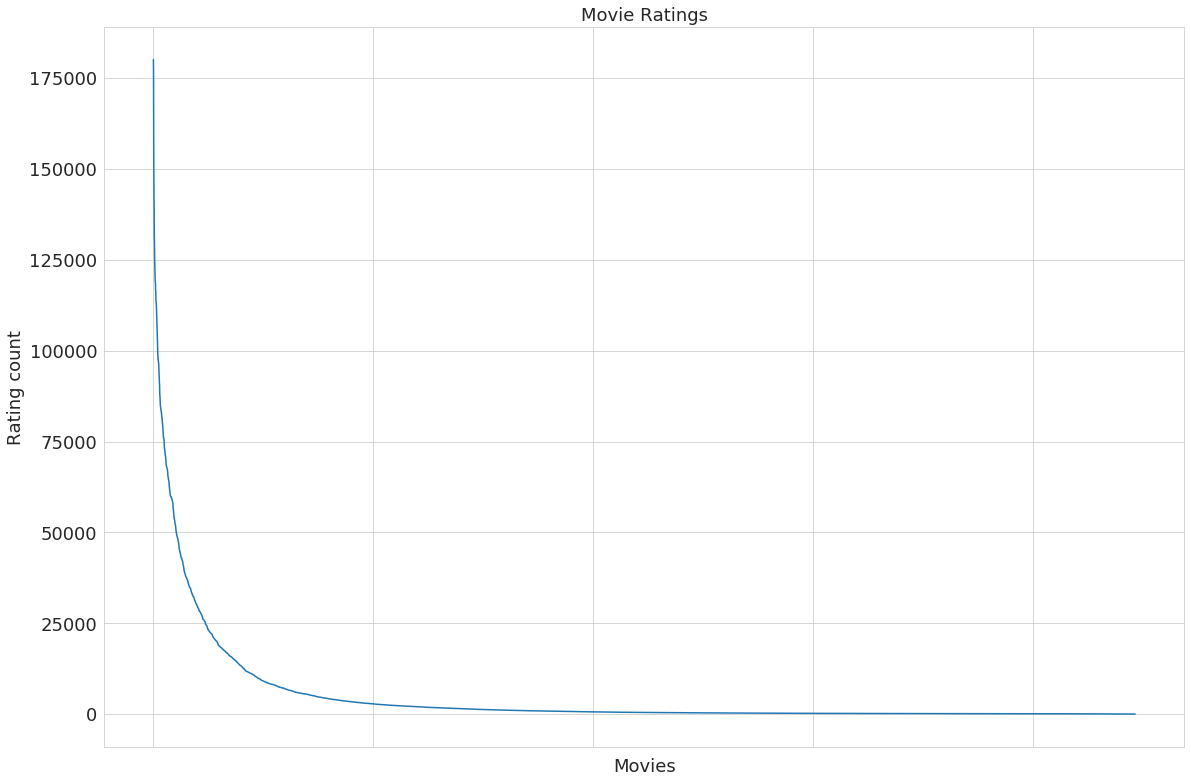

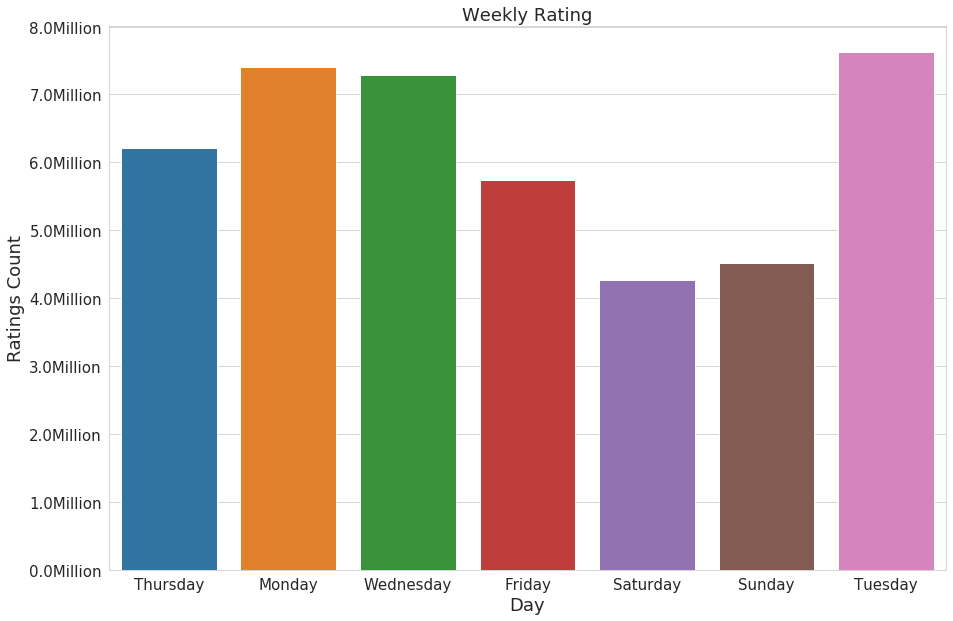

In [5]:
# Graph 3: Ratings per movie

movieRatings = trainingData.groupby(by = "Movie_ID")["Movie_Ratings"].count().sort_values(ascending = False)
pl = plt.figure(figsize = (15, 10))
graph = pl.add_axes([0.1,0.1,1,1])
plt.title("Movie Ratings", fontsize = 18)
plt.xlabel("Movies", fontsize = 18)
plt.ylabel("Rating count", fontsize = 18)
plt.plot(movieRatings.values)
plt.tick_params(labelsize = 18)
graph.set_xticklabels([])
plt.show()

#Graph 4: Weekly rating Graph
trainingData["day"] = trainingData.Rating_Date.dt.weekday_name

fig = plt.figure(figsize = (15, 10))
graph = sns.countplot(x = "day", data = trainingData)
graph.set_title("Weekly Rating", fontsize = 18)
graph.set_xlabel("Day", fontsize = 18)
graph.set_ylabel("Ratings Count", fontsize = 18)
graph.set_yticklabels([changingLabels(rating) for rating in graph.get_yticks()])
graph.tick_params(labelsize = 15)

plt.show()

In [0]:
# Create Sparse matrix

from scipy import sparse

## Train Data Sparse Matrix
if os.path.isfile("TrainingDataSparseMatrix.npz"):
    TrainingDataSparseMatrix = sparse.load_npz("TrainingDataSparseMatrix.npz")
    
else:
    TrainingDataSparseMatrix = sparse.csr_matrix((trainingData.Movie_Ratings, (trainingData.User_ID, trainingData.Movie_ID)))
    sparse.save_npz("TrainingDataSparseMatrix.npz", TrainingDataSparseMatrix)

## Test Data Sparse Matrix
if os.path.isfile("TestingDataSparseMatrix.npz"):
    TestingDataSparseMatrix = sparse.load_npz("TestingDataSparseMatrix.npz")
else:
    TestingDataSparseMatrix = sparse.csr_matrix((testingData.Movie_Ratings, (testingData.User_ID, testingData.Movie_ID)))
    sparse.save_npz("TestingDataSparseMatrix.npz", TestingDataSparseMatrix)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

if not os.path.isfile("MovieSimilarityMatrix.npz"):
    MovieSimilarityMatrix = cosine_similarity(TrainingDataSparseMatrix.T, dense_output = False)
    sparse.save_npz("MovieSimilarityMatrix.npz", MovieSimilarityMatrix)
else:
    MovieSimilarityMatrix = sparse.load_npz("MovieSimilarityMatrix.npz")

movieIDs = np.unique(MovieSimilarityMatrix.nonzero())
dictSimilarMovie = dict()
for id in movieIDs:
    similarity = np.argsort(-MovieSimilarityMatrix[id].toarray().ravel())[1:100]
    dictSimilarMovie[id] = similarity

dataframeMovie = pd.read_csv("movie_titles.csv",sep = ",", header = None, names=['ID', 'ReleaseYear', 'Title'], index_col = "ID", encoding = "iso8859_2")

movieID = 17764
dataframeMovie.loc[dictSimilarMovie[movieID][:10]]


,ReleaseYear,Title
ID,,
8904,1997.0,Good Will Hunting
16452,2000.0,Chocolat
15058,1999.0,Notting Hill
7193,1987.0,The Princess Bride
14928,1989.0,Dead Poets Society
15758,1984.0,Amadeus
16272,2000.0,Crouching Tiger
13763,1996.0,Jerry Maguire
13580,1988.0,A Fish Called Wanda


In [0]:
## Sparse Matrix for Machine Learning
def SparseMatrixSample(sparseMatrix, n_users, n_movies):
    
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)  
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    sparse.save_npz(path, sparse_sample)

    return sparse_sample


path = "TrainingDataSparseMatrixSamp.npz"
if not os.path.isfile(path):
    TrainingDataSparseMatrixSamp = SparseMatrixSample(TrainingDataSparseMatrix, 4000, 400)
else:
    TrainingDataSparseMatrixSamp = sparse.load_npz(path)

path = "TestingDataSparseMatrixSamp.npz"
if not os.path.isfile(path):
    TestingDataSparseMatrixSamp = SparseMatrixSample(TestingDataSparseMatrix, 2000, 200)
else:
    TestingDataSparseMatrixSamp = sparse.load_npz(path)


In [0]:
#define average function
def Avg(data, if_user):
    avg = 1 if if_user else 0
    ratingsSum = data.sum(axis = avg).A1  
    ratingsCount = (data!=0).sum(axis = avg).A1  
    r, c = data.shape
    avgRat = {n: ratingsSum[n]/ratingsCount[n] for n in range(r if if_user else c) if ratingsCount[n]!=0}
    return avgRat

# Average rating per USer
UserRatingsAverage = Avg(TrainingDataSparseMatrixSamp, True)

# Average rating per Movie
MovieRatingsAverage = Avg(TrainingDataSparseMatrixSamp, False)



In [0]:
from sklearn.metrics.pairwise import cosine_similarity
trainingUser, trainingMovies, trainingRatings = sparse.find(TrainingDataSparseMatrixSamp)

# feature extraction for train data

if os.path.isfile("Training.csv"):
    print("Continue")
else:
    with open("Training.csv", mode = "w") as csvWrite:
        for userID, movieID, movieRating in zip(trainingUser, trainingMovies, trainingRatings):
            eachRowData = list()

            eachRowData.append(userID) 
            eachRowData.append(movieID) 
            eachRowData.append(TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero())

            userSimilarity = cosine_similarity(TrainingDataSparseMatrixSamp[userID], TrainingDataSparseMatrixSamp).ravel()
            userSimilarityIndex = np.argsort(-userSimilarity)[1:]
            userSimilarityRat = TrainingDataSparseMatrixSamp[userSimilarityIndex, movieID].toarray().ravel()
            userSimilarityRatTop = list(userSimilarityRat[userSimilarityRat != 0][:5])
            userSimilarityRatTop.extend([MovieRatingsAverage[movieID]]*(5-len(userSimilarityRatTop)))
            movieSimilarity = cosine_similarity(TrainingDataSparseMatrixSamp[:,movieID].T, TrainingDataSparseMatrixSamp.T).ravel()
            movieSimilarityIndex = np.argsort(-movieSimilarity)[1:]
            movieSimilarityRat = TrainingDataSparseMatrixSamp[userID, movieSimilarityIndex].toarray().ravel()
            movieSimilarityRatTop = list(movieSimilarityRat[movieSimilarityRat != 0][:5])
            movieSimilarityRatTop.extend([UserRatingsAverage[userID]]*(5-len(movieSimilarityRatTop)))

            eachRowData.extend(userSimilarityRatTop)
            eachRowData.extend(movieSimilarityRatTop)
            eachRowData.append(UserRatingsAverage[userID])
            eachRowData.append(MovieRatingsAverage[movieID])
            eachRowData.append(movieRating)

            csvWrite.write(",".join(map(str, eachRowData)))
            csvWrite.write("\n")
    
trainData = pd.read_csv("Training.csv", names = ["User_ID", "Movie_ID", "globalAvg", "user1Rating","user2Rating", "user3Rating", "user4Rating", "user5Rating", "movie1Rating", "movie2Rating", "movie3Rating", "movie4Rating", "movie5Rating", "userAvg", "movieAvg", "userRating"])

# feature extraction for test data

testingUser, testingMovies, testingRatings = sparse.find(TestingDataSparseMatrixSamp)
if os.path.isfile("Testing.csv"):
    print("Continue")
else:
    with open("Testing.csv", mode = "w") as csvWrite:

        for userID, movieID, movieRating in zip(testingUser, testingMovies, testingRatings):
            eachRowData = list()

            eachRowData.append(userID) 
            eachRowData.append(movieID) 
            eachRowData.append(TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero())
            try:
              userSimilarity = cosine_similarity(TrainingDataSparseMatrixSamp[userID], TrainingDataSparseMatrixSamp).ravel()
              userSimilarityIndex = np.argsort(-userSimilarity)[1:]
              userSimilarityRat = TrainingDataSparseMatrixSamp[userSimilarityIndex, movieID].toarray().ravel()
              userSimilarityRatTop = list(userSimilarityRat[userSimilarityRat != 0][:5])
              userSimilarityRatTop.extend([MovieRatingsAverage[movieID]]*(5-len(userSimilarityRatTop)))
              eachRowData.extend(userSimilarityRatTop)
            except(IndexError, KeyError):
              avg = [TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero()]*5
              eachRowData.extend(avg)
            except:
              raise
            try:
              movieSimilarity = cosine_similarity(TrainingDataSparseMatrixSamp[:,movieID].T, TrainingDataSparseMatrixSamp.T).ravel()
              movieSimilarityIndex = np.argsort(-movieSimilarity)[1:]
              movieSimilarityRat = TrainingDataSparseMatrixSamp[userID, movieSimilarityIndex].toarray().ravel()
              movieSimilarityRatTop = list(movieSimilarityRat[movieSimilarityRat != 0][:5])
              movieSimilarityRatTop.extend([UserRatingsAverage[userID]]*(5-len(movieSimilarityRatTop)))
              eachRowData.extend(movieSimilarityRatTop)
            except(IndexError, KeyError):
              avg = [TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero()]*5
              eachRowData.extend(avg)
            except:
              raise
   
            try:    
              eachRowData.append(UserRatingsAverage[userID])
            except( KeyError):
              avg = [TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero()]
              eachRowData.extend(avg)
            except:
              raise
            try:
              eachRowData.append(MovieRatingsAverage[movieID])
            except( KeyError):
              avg = [TrainingDataSparseMatrixSamp.sum()/TrainingDataSparseMatrixSamp.count_nonzero()]
              eachRowData.extend(avg)
            except:
              raise

            eachRowData.append(movieRating)

            csvWrite.write(",".join(map(str, eachRowData)))
            csvWrite.write("\n")    

testData = pd.read_csv("Testing.csv", names = ["User_ID", "Movie_ID", "globalAvg", "user1Rating","user2Rating", "user3Rating", "user4Rating", "user5Rating", "movie1Rating", "movie2Rating", "movie3Rating", "movie4Rating", "movie5Rating", "userAvg", "movieAvg", "userRating"])

In [13]:
!pip install scikit-surprise

from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

     |████████████████████████████████| 6.5MB 2.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678212 sha256=7a31dceb6f1cc808d479259a2e22eee0a57edff1b03a93439daec15a539b1937
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# Transforming for lib

r = Reader(rating_scale=(1, 5))

projectData = Dataset.load_from_df(trainData[['User_ID', 'Movie_ID', 'userRating']], r)

dataTrainingSet = projectData.build_full_trainset()
dataTestingSet = list(zip(testData["User_ID"].values, testData["Movie_ID"].values, testData["userRating"].values))

In [0]:
# defining all performance related metrics and error definition 
# Graph and table metrics definition

performanceMetrics = pd.DataFrame(columns = ["Model Used", "RMSE on Train", "MAPE on Train", "RMSE on Test", "MAPE on Test"])
trainingResultOnModels = dict()
testingResultOnModels = dict()

def performanceMetricsTable(modelUsed, trainRMSE, trainMAPE, testRMSE, testMAPE):
    global performanceMetrics
    performanceMetrics = performanceMetrics.append(pd.DataFrame([[modelUsed, trainRMSE, trainMAPE, testRMSE, testMAPE]], columns =["Model Used", "RMSE on Train", "MAPE on Train", "RMSE on Test", "MAPE on Test"]))
    performanceMetrics.reset_index(drop = True, inplace = True)

def metricsErrorPerformance(train_YData, train_YPred):
    RMSE = np.sqrt(mean_squared_error(train_YData, train_YPred))
    MAPE = np.mean(abs((train_YData - train_YPred)/train_YData))*100
    return RMSE, MAPE

def plot_importance(modelUsed, clf):
    figure = plt.figure(figsize = (12, 9))
    graph = figure.add_axes([0,0,1,1])
    modelUsed.plot_importance(clf, ax = graph, height = 0.5)
    plt.xlabel("For Each Feature the F-Score", fontsize = 18)
    plt.ylabel("List of Features", fontsize = 18)
    plt.title("F-Score for Each Feature(Importance)", fontsize = 18)
    plt.tick_params(labelsize = 18)
    plt.show()

def movieRatings(valuePredicted):
    ratingTrue = np.array([value.r_ui for value in valuePredicted])
    ratingpredicted = np.array([value.est for value in valuePredicted])
    return ratingTrue, ratingpredicted
    
def errorMetricsValue(valuePredicted):
    ratingTrue, ratingpredicted = movieRatings(valuePredicted)
    RMSE = np.sqrt(mean_squared_error(ratingTrue, ratingpredicted)) 
    MAPE = np.mean(abs((ratingTrue - ratingpredicted)/ratingTrue))*100
    return RMSE, MAPE

In [0]:
def trainModelOnXGBOOST(train_XData, test_XData, train_YData, test_YData, modelUsed):
    
    # to store result of training and testing on each model
    resultOnTrain = dict()
    resultOnTest = dict()
    
    # To fit data in XGBoost
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(train_XData, train_YData)
    
    print(modelUsed)

    # print training data result error metrics
    print("\n Error Metric Result on Training Data Set \n")
    train_YPred = clf.predict(train_XData)
    trainRMSE, trainMAPE = metricsErrorPerformance(train_YData, train_YPred)
    print("Root Mean Square Error(RMSE): = {}".format(trainRMSE))
    print("Mean Absolute Percentage Error(MAPE): = {}".format(trainMAPE))
    print("\n")

    # print testing data result error metrics
    print("\n Error Metric Result on Testing Data Set \n")
    test_YPred = clf.predict(test_XData)
    testRMSE, testMAPE = metricsErrorPerformance(test_YData, test_YPred)
    print("Root Mean Square Error(RMSE): = {}".format(testRMSE))
    print("Mean Absolute Percentage Error(MAPE): = {}".format(testMAPE))
    
    # ploting the graph of response    
    plot_importance(xgb, clf)

    # storing the result
    resultOnTrain = {"RMSE": trainRMSE, "MAPE": trainMAPE, "Prediction": train_YPred}
    resultOnTest = {"RMSE": testRMSE, "MAPE": testMAPE, "Prediction": test_YPred}
            
    #Tabular form of metrics table
    performanceMetricsTable(modelUsed, trainRMSE, trainMAPE, testRMSE, testMAPE)
    
    return resultOnTrain, resultOnTest

In [0]:
import random

seed = 15
random.seed(seed)
np.random.seed(seed)

def trainOnSurpriseModel(useAlgorithm, dataTrainingSet, dataTestingSet, modelUsed):

    surpriseTrain = dict()
    surpriseTest = dict()
    
    useAlgorithm.fit(dataTrainingSet)
    
    print(modelUsed)

    # print training data result error metrics
    print("\n Error Metric Result on Training Data Set \n")
    predictionData = useAlgorithm.test(dataTrainingSet.build_testset())
    ratingTrue, train_ratingpredicted = movieRatings(predictionData)
    trainRMSE, trainMAPE = errorMetricsValue(predictionData)
    print("Root Mean Square Error(RMSE): = {}".format(trainRMSE))
    print("Mean Absolute Percentage Error(MAPE): = {}".format(trainMAPE))
    print("\n")

    # print training data result error metrics
    print("\n Error Metric Result on Testing Data Set \n")
    predictionData = useAlgorithm.test(dataTestingSet)
    ratingTrue, test_ratingpredicted = movieRatings(predictionData)
    testRMSE, testMAPE = errorMetricsValue(predictionData)
    print("Root Mean Square Error(RMSE): = {}".format(testRMSE))
    print("Mean Absolute Percentage Error(MAPE): = {}".format(testMAPE))
        
    
    # storing the result
    surpriseTrain = {"RMSE": trainRMSE, "MAPE": trainMAPE, "Prediction": train_ratingpredicted}
    surpriseTest = {"RMSE": testRMSE, "MAPE": testMAPE, "Prediction": test_ratingpredicted}
            
    #Tabular form of metrics table
    performanceMetricsTable(modelUsed, trainRMSE, trainMAPE, testRMSE, testMAPE)
    
    return surpriseTrain, surpriseTest

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost 13

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.8105686945196948
Mean Absolute Percentage Error(MAPE): = 24.1616427898407



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.0722769984483742
Mean Absolute Percentage Error(MAPE): = 33.160274170446975


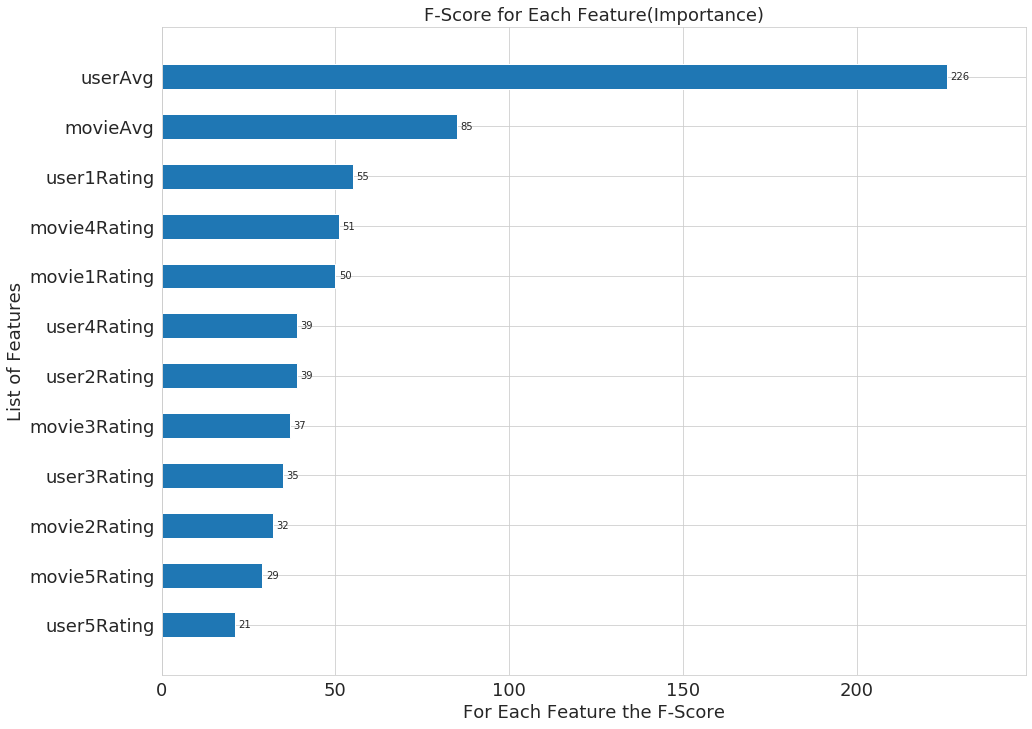

In [19]:
# -- XGBoost 13 

train_XData = trainData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
train_YData = trainData["userRating"]

test_XData = testData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
test_YData = testData["userRating"]

resultOnTrain, resultOnTest =  trainModelOnXGBOOST(train_XData, test_XData, train_YData, test_YData, "XGBoost 13")

trainingResultOnModels["XGBoost 13 Model"] = resultOnTrain
testingResultOnModels["XGBoost 13 Model"] = resultOnTest

In [20]:
# -- Surprise BaselineOnly Model

algoBSLOption = {"method":"sgd", "learning_rate":0.01, "n_epochs":50}
modelParam = BaselineOnly(bsl_options=algoBSLOption)

resultOnTrain, resultOnTest = trainOnSurpriseModel(modelParam, dataTrainingSet, dataTestingSet, "Baseline Only")

trainingResultOnModels["Baseline Only"] = resultOnTrain
testingResultOnModels["Baseline Only"] = resultOnTest

Estimating biases using sgd...
Baseline Only

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.8633125297646939
Mean Absolute Percentage Error(MAPE): = 26.274463823024917



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.0678792938165431
Mean Absolute Percentage Error(MAPE): = 33.39606450015828


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:16:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB + BSL

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.8107161339922456
Mean Absolute Percentage Error(MAPE): = 24.17806386947632



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.0722471963342237
Mean Absolute Percentage Error(MAPE): = 33.160161018717204


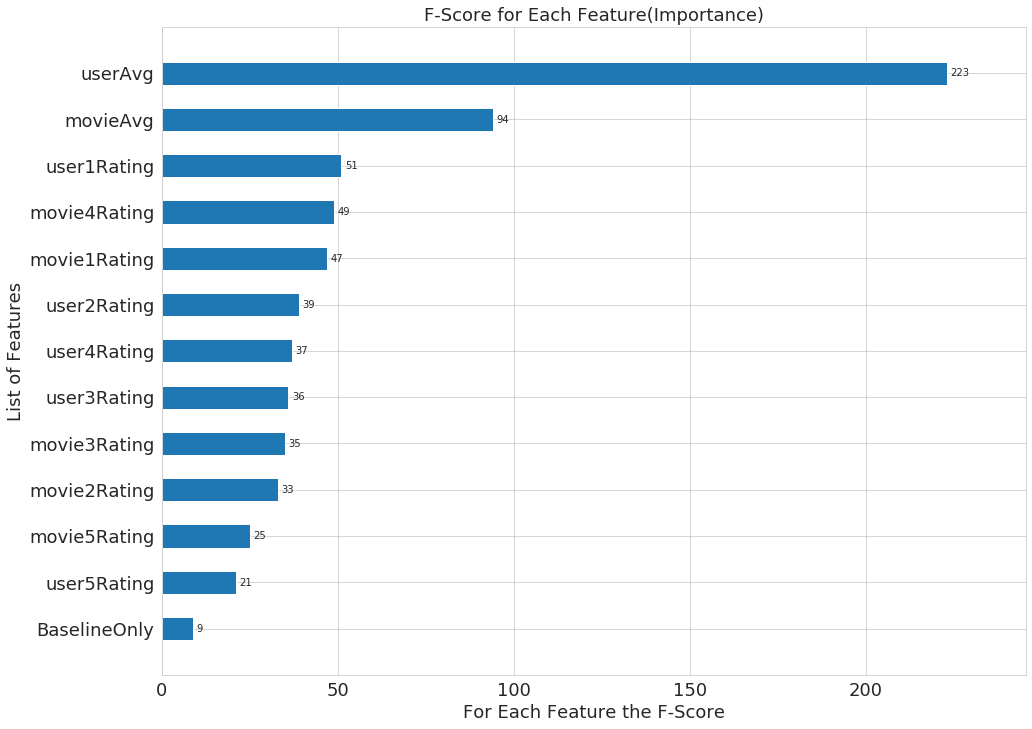

In [21]:
# -- XGBoost + Surprise BaselineOnly model

trainData["BaselineOnly"] = trainingResultOnModels["Baseline Only"]["Prediction"]
testData["BaselineOnly"] = testingResultOnModels["Baseline Only"]["Prediction"]

train_XData = trainData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
train_YData = trainData["userRating"]

test_XData = testData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
test_YData = testData["userRating"]

resultOnTrain, resultOnTest =  trainModelOnXGBOOST(train_XData, test_XData, train_YData, test_YData, "XGB + BSL")

trainingResultOnModels["XGB + BSL"] = resultOnTrain
testingResultOnModels["XGB + BSL"] = resultOnTest

In [22]:
# KNNBaseline User - User

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(projectData)
algoBSLOption = {'method': 'sgd'} 

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=algoBSLOption)
resultOnTrain, resultOnTest = trainOnSurpriseModel(algo, dataTrainingSet, dataTestingSet, "KNNBaseline_User")
trainingResultOnModels["KNNBaseline_User"] = resultOnTrain
testingResultOnModels["KNNBaseline_User"] = resultOnTest

# KNN Baseline Item - Item
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(projectData)


sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=algoBSLOption)
resultOnTrain, resultOnTest = trainOnSurpriseModel(algo, dataTrainingSet, dataTestingSet, "KNNBaseline_Item")
trainingResultOnModels["KNN + Baseline Item"] = resultOnTrain
testingResultOnModels["KNN + Baseline Item"] = resultOnTest

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

[04:19:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB_BSL_KNN

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.8106094286490615
Mean Absolute Percentage Error(MAPE): = 24.18375462293625



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.0685637416972407
Mean Absolute Percentage Error(MAPE): = 33.36120456197979


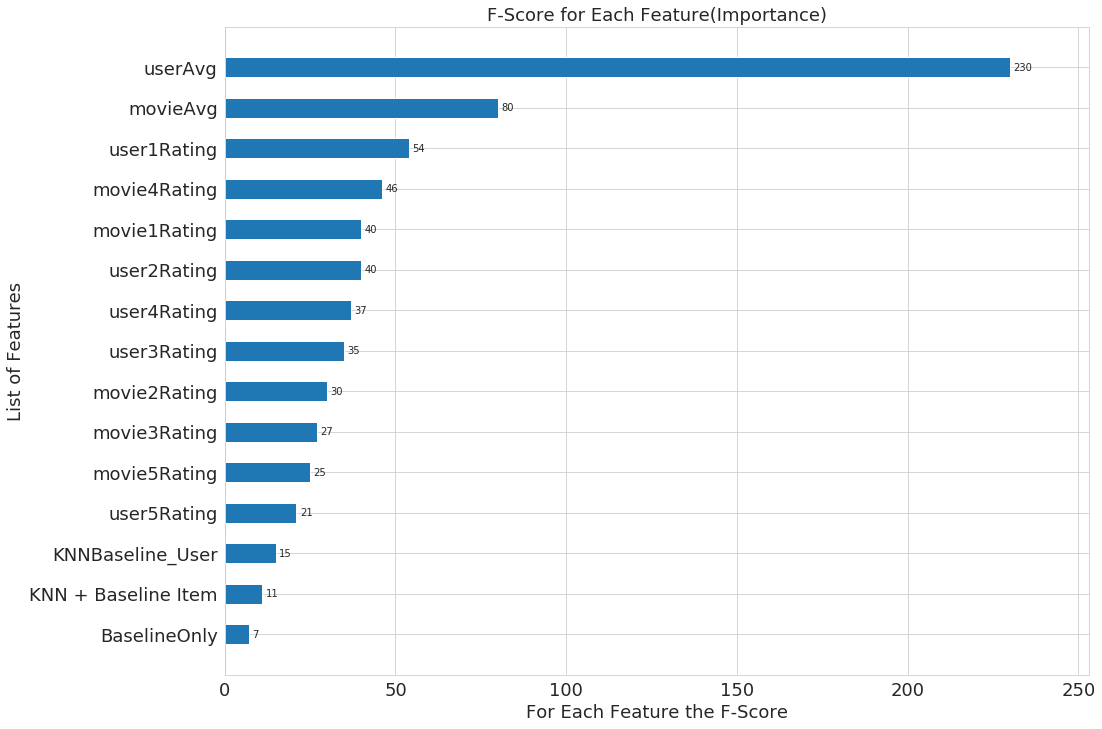

In [23]:
# XGBoost13 + Surprise BaselinOnly + Surprise KNN

trainData["KNNBaseline_User"] = trainingResultOnModels["KNNBaseline_User"]["Prediction"]
trainData["KNN + Baseline Item"] = trainingResultOnModels["KNN + Baseline Item"]["Prediction"]

testData["KNNBaseline_User"] = testingResultOnModels["KNNBaseline_User"]["Prediction"]
testData["KNN + Baseline Item"] = testingResultOnModels["KNN + Baseline Item"]["Prediction"]

train_XData = trainData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
train_YData = trainData["userRating"]

test_XData = testData.drop(["User_ID", "Movie_ID", "userRating"], axis = 1)
test_YData = testData["userRating"]

resultOnTrain, resultOnTest =  trainModelOnXGBOOST(train_XData, test_XData, train_YData, test_YData, "XGB_BSL_KNN")

trainingResultOnModels["XGB_BSL_KNN"] = resultOnTrain
testingResultOnModels["XGB_BSL_KNN"] = resultOnTest

In [28]:
# SVD
parameters  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}
gridSearch = GridSearchCV(SVD, parameters, measures=['rmse', 'mae'], cv=3)
gridSearch.fit(projectData)
useAlgorithnm = SVD(n_factors = gridSearch.best_params['rmse']['n_factors'], biased=True, verbose=True)

resultOnTrain, resultOnTest = trainOnSurpriseModel(useAlgorithnm, dataTrainingSet, dataTestingSet, "SVD")

trainingResultOnModels["SVD"] = resultOnTrain
testingResultOnModels["SVD"] = resultOnTest

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
SVD

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.9005523199299388
Mean Absolute Percentage Error(MAPE): = 28.221082303488405



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.0676516679171406
Mean Absolute Percentage Error(MAPE): = 33.398104934265376


In [29]:
# SVD++
parameters = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}
gridSearch = GridSearchCV(SVDpp, parameters, measures=['rmse', 'mae'], cv=3)
gridSearch.fit(projectData)
useAlgorithnm = SVDpp(n_factors = gridSearch.best_params['rmse']['n_factors'], lr_all = gridSearch.best_params['rmse']["lr_all"], verbose=True)

resultOnTrain, resultOnTest = trainOnSurpriseModel(useAlgorithnm, dataTrainingSet, dataTestingSet, "SVD++")

trainingResultOnModels["SVD++"] = resultOnTrain
testingResultOnModels["SVD++"] = resultOnTest

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
SVD++

 Error Metric Result on Training Data Set 

Root Mean Square Error(RMSE): = 0.7866983159485371
Mean Absolute Percentage Error(MAPE): = 24.052952287216144



 Error Metric Result on Testing Data Set 

Root Mean Square Error(RMSE): = 1.067634767316242
Mean Absolute Percentage Error(MAPE): = 33.39808014582436


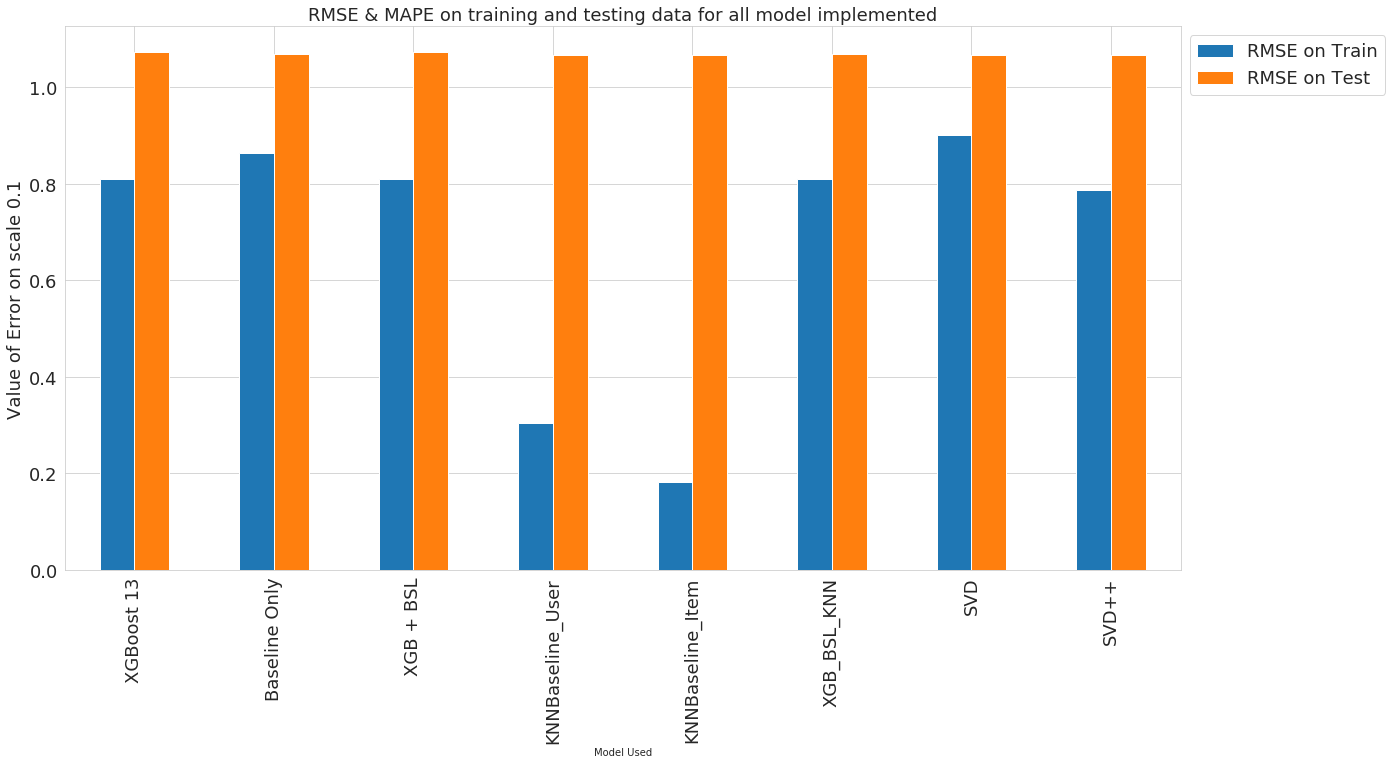

,Model Used,RMSE on Train,RMSE on Test
0,XGBoost 13,0.810569,1.07228
1,Baseline Only,0.863313,1.06788
2,XGB + BSL,0.810716,1.07225
3,KNNBaseline_User,0.304498,1.06765
4,KNNBaseline_Item,0.181651,1.06765
5,XGB_BSL_KNN,0.810609,1.06856
6,SVD,0.900552,1.06765
7,SVD++,0.786698,1.06763


In [30]:
allModelErrorMetricsTable = performanceMetrics.drop(["MAPE on Train", "MAPE on Test"], axis = 1)
allModelErrorMetricsTable.plot(x = "Model Used", kind = "bar", figsize = (20, 10), grid = True, fontsize = 18)
plt.title("RMSE & MAPE on training and testing data for all model implemented", fontsize = 18)
plt.ylabel("Value of Error on scale 0.1", fontsize = 18)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 18)
plt.show()
performanceMetrics.drop(["MAPE on Train", "MAPE on Test"], axis = 1).style.highlight_min(axis=0)